In [21]:
import pandas as pd

# Load the datasets
train_logs = pd.read_csv('train_logs_aggregated.csv')
train_scores = pd.read_csv('train_scores.csv')
combined_data = pd.merge(train_logs, train_scores, on='id')
combined_data.head()

test_logs = pd.read_csv('test_logs_aggregated.csv')
test_scores = pd.read_csv('test_scores_aggregated.csv')

In [41]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Lasso Regression with cross-validation for hyperparameter tuning
# Define a range of alpha values (regularization strength)
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

lasso = Lasso()
lasso_grid = GridSearchCV(lasso, parameters, cv=5)
lasso_grid.fit(X_train, y_train)

# Best parameter and corresponding score
best_alpha = lasso_grid.best_params_
best_score_lasso = lasso_grid.best_score_

# Evaluate on the validation set
lasso_best = Lasso(alpha=best_alpha['alpha'])
lasso_best.fit(X_train, y_train)
y_pred_val_lasso = lasso_best.predict(X_val)
mse_val_lasso = mean_squared_error(y_val, y_pred_val_lasso)

print(best_alpha, mse_val_lasso)
# Making predictions on the test data using the trained Lasso model
y_pred_test_lasso = lasso_best.predict(X_test_normalized)

# Creating a DataFrame to compare predicted and actual scores for Lasso
test_predictions_lasso = pd.DataFrame({'id': test_logs['id'], 'predicted_score_lasso': y_pred_test_lasso})
test_actual_vs_predicted_lasso = pd.merge(test_predictions_lasso, test_scores, on='id')

# Calculating MSE for the Lasso predictions on test data
mse_test_lasso = mean_squared_error(test_actual_vs_predicted_lasso['score'], test_actual_vs_predicted_lasso['predicted_score_lasso'])

print(mse_test_lasso)
# Analyzing the coefficients of the Lasso model to see which variables are most predictive
lasso_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_best.coef_})

# Sorting the features by the absolute value of their coefficients in descending order
lasso_coefficients['Abs_Coefficient'] = abs(lasso_coefficients['Coefficient'])
lasso_coefficients_sorted = lasso_coefficients.sort_values(by='Abs_Coefficient', ascending=False)

print(lasso_coefficients_sorted.head())  # Displaying the top features

{'alpha': 0.001} 0.5741590269685255
0.49665764935762025
               Feature  Coefficient  Abs_Coefficient
4        Nonproduction     1.377283         1.377283
9  count_special_chars    -1.325745         1.325745
2                Input     0.742684         0.742684
6           Remove/Cut    -0.151553         0.151553
8        count_letters     0.091726         0.091726


In [44]:
#KNN REGRESSIOn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

X = combined_data.drop(['id', 'score'], axis=1)  # Dropping 'id' as it's not a feature
y = combined_data['score']

# Normalizing the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor()

parameters_expanded = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Using GridSearchCV to find the best parameters
knn_grid_expanded = GridSearchCV(knn, parameters_expanded, cv=5)
knn_grid_expanded.fit(X_train, y_train)

# Best parameters and corresponding score
best_params_expanded = knn_grid_expanded.best_params_
best_score_expanded = knn_grid_expanded.best_score_

# Evaluate on the validation set
knn_best_expanded = KNeighborsRegressor(**best_params_expanded)
knn_best_expanded.fit(X_train, y_train)
y_pred_val_expanded = knn_best_expanded.predict(X_val)
mse_val_expanded = mean_squared_error(y_val, y_pred_val_expanded)

print(best_params_expanded, mse_val_expanded)
# Preparing test data for predictions
X_test = test_logs.drop('id', axis=1)  # Dropping 'id' as it's not a feature
X_test_normalized = scaler.transform(X_test)  # Normalizing the test data

# Making predictions on the test data
y_pred_test = knn_grid_expanded.predict(X_test_normalized)

# Creating a DataFrame to compare predicted and actual scores
test_predictions = pd.DataFrame({'id': test_logs['id'], 'predicted_score': y_pred_test})
test_actual_vs_predicted = pd.merge(test_predictions, test_scores, on='id')

# Calculating MSE for the test data
mse_test = mean_squared_error(test_actual_vs_predicted['score'], test_actual_vs_predicted['predicted_score'])

print(mse_test)
from sklearn.inspection import permutation_importance
# Compute permutation feature importance again
perm_importance = permutation_importance(knn_best, X_val, y_val, n_repeats=10, random_state=42)

# Extracting feature importance values and corresponding feature names
feature_importances = perm_importance.importances_mean
features = combined_data.drop(['id', 'score'], axis=1).columns

# Creating a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

# Sorting the features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'} 0.5203514034518791
0.418582976014605
                feature  importance
10     final_word_count    0.138630
2                 Input    0.137441
8         count_letters    0.064555
6            Remove/Cut    0.027773
7               Replace    0.015079
1       avg_action_time    0.010411
0           time_worked    0.006775
9   count_special_chars   -0.000102
4         Nonproduction   -0.000178
3          Move From To   -0.001845
5                 Paste   -0.005282


In [45]:
#GRADIENT BOOSTER
from sklearn.ensemble import GradientBoostingRegressor

# Initialize Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)

# Train the model on the training data
gb_regressor.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_val_gb = gb_regressor.predict(X_val)
mse_val_gb = mean_squared_error(y_val, y_pred_val_gb)

print(mse_val_gb)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Create a base model
gb = GradientBoostingRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

# Train the best model on the full training set
best_gb = GradientBoostingRegressor(**best_params)
best_gb.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_val_best = best_gb.predict(X_val)
mse_val_best = mean_squared_error(y_val, y_pred_val_best)
print(mse_val_best)
# Making predictions on the test data with the Gradient Boosting Regressor
y_pred_test_gb = best_gb.predict(X_test_normalized)

# Creating a DataFrame to compare predicted and actual scores for Gradient Boosting
test_predictions_gb = pd.DataFrame({'id': test_logs['id'], 'predicted_score_gb': y_pred_test_gb})
test_actual_vs_predicted_gb = pd.merge(test_predictions_gb, test_scores, on='id')

# Calculating MSE for the test data with Gradient Boosting
mse_test_gb = mean_squared_error(test_actual_vs_predicted_gb['score'], test_actual_vs_predicted_gb['predicted_score_gb'])
print(mse_test_gb)

0.5159145020701013
Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min

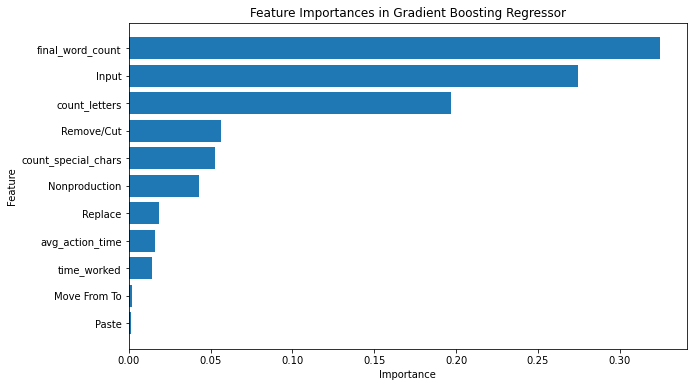

,Feature,Importance
10,final_word_count,0.324556
2,Input,0.274353
8,count_letters,0.197060
6,Remove/Cut,0.056338
9,count_special_chars,0.052856
4,Nonproduction,0.042850
7,Replace,0.018764
1,avg_action_time,0.015858
0,time_worked,0.014208
3,Move From To,0.001982


In [30]:
import matplotlib.pyplot as plt

# Extracting feature importances
feature_importances = best_gb.feature_importances_

# Creating a DataFrame for easier visualization
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Gradient Boosting Regressor')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

features_df

In [47]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert the 'score' to discrete values for classification
y_classification = y_regression.apply(lambda x: int(x))

# Splitting the dataset into training and testing sets for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_classification, test_size=0.3, random_state=42)

# Initialize Random Forest Classifier
rf_cls = RandomForestClassifier(random_state=42)

# Fitting the Random Forest Classifier to the training data
rf_cls.fit(X_train_cls, y_train_cls)


# Define your parameter grid and initialize RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                   param_grid, n_iter=100, cv=5, verbose=2, 
                                   random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train_cls, y_train_cls)

# Best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
print(best_params)
print(best_score)

0.49409780775716694
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.14      0.22        29
           2       0.29      0.24      0.26        58
           3       0.52      0.58      0.55       200
           4       0.53      0.64      0.58       220
           5       0.39      0.26      0.31        73
           6       0.00      0.00      0.00        12

    accuracy                           0.49       593
   macro avg       0.32      0.27      0.27       593
weighted avg       0.47      0.49      0.47       593

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=30, max_

In [50]:
# Predicting on the test set
random_search_predictions = random_search.predict(X_test_cls)

# Evaluating the model
accuracy_rf_cls = accuracy_score(y_test_cls, random_search_predictions)
report_rf_cls = classification_report(y_test_cls, random_search_predictions)

print(accuracy_rf_cls)
print(report_rf_cls)

0.4974704890387858
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.62      0.17      0.27        29
           2       0.29      0.21      0.24        58
           3       0.51      0.59      0.55       200
           4       0.53      0.64      0.58       220
           5       0.41      0.26      0.32        73
           6       0.00      0.00      0.00        12

    accuracy                           0.50       593
   macro avg       0.34      0.27      0.28       593
weighted avg       0.48      0.50      0.48       593



In [49]:
feature_importances = rf_cls.feature_importances_
feature_names = X.columns  # Assuming X is a DataFrame with column names
features_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
for name, importance in features_sorted:
    print(f"{name}: {importance}")

final_word_count: 0.1635273486863625
Input: 0.14824349834788988
count_letters: 0.13315291878786525
Remove/Cut: 0.10984671515259567
time_worked: 0.10184370650990411
avg_action_time: 0.09853878020186842
count_special_chars: 0.09553971205047761
Nonproduction: 0.09391492749947371
Replace: 0.03990399696670322
Paste: 0.013016769618524018
Move From To: 0.002471626178335468
